In [20]:
import argparse
import os
import sys
from concurrent.futures import ThreadPoolExecutor
from shutil import copy2
from typing import List, Set, Tuple
from sklearn.metrics import confusion_matrix
import json
from matplotlib import pyplot as plt

import pandas as pd

from validate_model import ValidateModel

In [93]:


class ValidateMultipleModels(ValidateModel):
    """
    Class for validating data from multiple models.
    Inherits from ValidateModel
    """

    def __init__(self, config_file_name: str, files_list: Set[str], n_workers: int = 1):
        super().__init__(-12, 12, False, config_file_name, None)
        self.particles_df = self.__load_pickles(files_list, n_workers)
        self.config=config_file_name

    @staticmethod
    def __load_pickles(files_list: Set[str], n_workers: int = 1) -> pd.DataFrame:
        """Loads multiple pickle files produced by validate_model module.

        Args:
            files_list (Set[str]): Files list containg picle files with datasets.
            n_workers (int, optional): Number of workers for multithreading. Defaults to 1.

        Returns:
            pd.DataFrame: Dataframe with merged datasets.
        """
        with ThreadPoolExecutor(max_workers=n_workers) as executor:
            results = list(executor.map(pd.read_pickle, files_list))
            whole_df = pd.concat(results, ignore_index=True)
            return whole_df
    @staticmethod
    def get_df_p_slice(df:pd.DataFrame, low_p : float, hi_p: float)->pd.DataFrame:
        temp = df.loc[df['Complex_p'] > low_p ]
        return temp.loc[df['Complex_p'] < hi_p]

    @staticmethod
    def get_bins_from_config(config_file_name: str)->List:
        with open(config_file_name, "r") as fp:
            d = json.load(fp)
            return d["bins"]
    
    def get_stats(self, particles:pd.DataFrame, particle_id: int, low_p:float, hi_p:float)->Tuple[float,float]:
        df = self.get_df_p_slice(particles, low_p, hi_p)

        cnf_matrix = confusion_matrix(
            df[self.pid_variable_name], df["xgb_preds"]
        )
        return self.efficiency_stats(cnf_matrix,particle_id, print_output=False)

    def plot_stats(self, particle_id:int):
        bins = self.get_bins_from_config(self.config)
        efficiencies=[]
        purities=[]
        bin_mids=[]
        for i in range(0, len(bins) - 1):
            lo, hi = bins[i: i+2]
            efficiency, purity = self.get_stats(self.particles_df, particle_id, lo, hi)
            efficiencies.append(efficiency)
            purities.append(purity)
            bin_mids.append((lo+hi)/2)

        plt.plot(bin_mids, efficiencies,"--o", label="Efficiency %", color="purple")
        plt.plot(bin_mids, purities,"--x", label="Purity %", color="green")
        plt.title(f"Purity and efficiency {particle_id}")
        plt.vlines(bins,[0 for b in bins],[100 for b in bins], color='grey', linestyle='dotted', label='bin edge')
        plt.xlabel("p [GeV/C]")
        plt.ylabel("%")
        plt.legend()
        plt.savefig(f"purity_efficiency_{particle_id}", dpi=350)
        plt.close()



In [96]:

json_file_name = "/tmp/lustre/cbm/users/tfic/ml-pid-cbm/ml_pid_cbm/slurm_config.json"
models = [
"/tmp/lustre/cbm/users/tfic/pid/train_20230801_092302/model_0.0_0.9_positive",
"/tmp/lustre/cbm/users/tfic/pid/train_20230801_092302/model_0.9_1.4_positive",
"/tmp/lustre/cbm/users/tfic/pid/train_20230801_092302/model_1.4_2.1_positive",
"/tmp/lustre/cbm/users/tfic/pid/train_20230801_092302/model_2.1_3.5_positive",
"/tmp/lustre/cbm/users/tfic/pid/train_20230801_092302/model_3.5_12.0_positive",
]

n_workers = 4
pickle_files = {f"{model}/validated_data.pickle" for model in models}
validate = ValidateMultipleModels(json_file_name, pickle_files, n_workers)

OSError: [Errno 107] Transport endpoint is not connected: 'purity_efficiency_0.png'

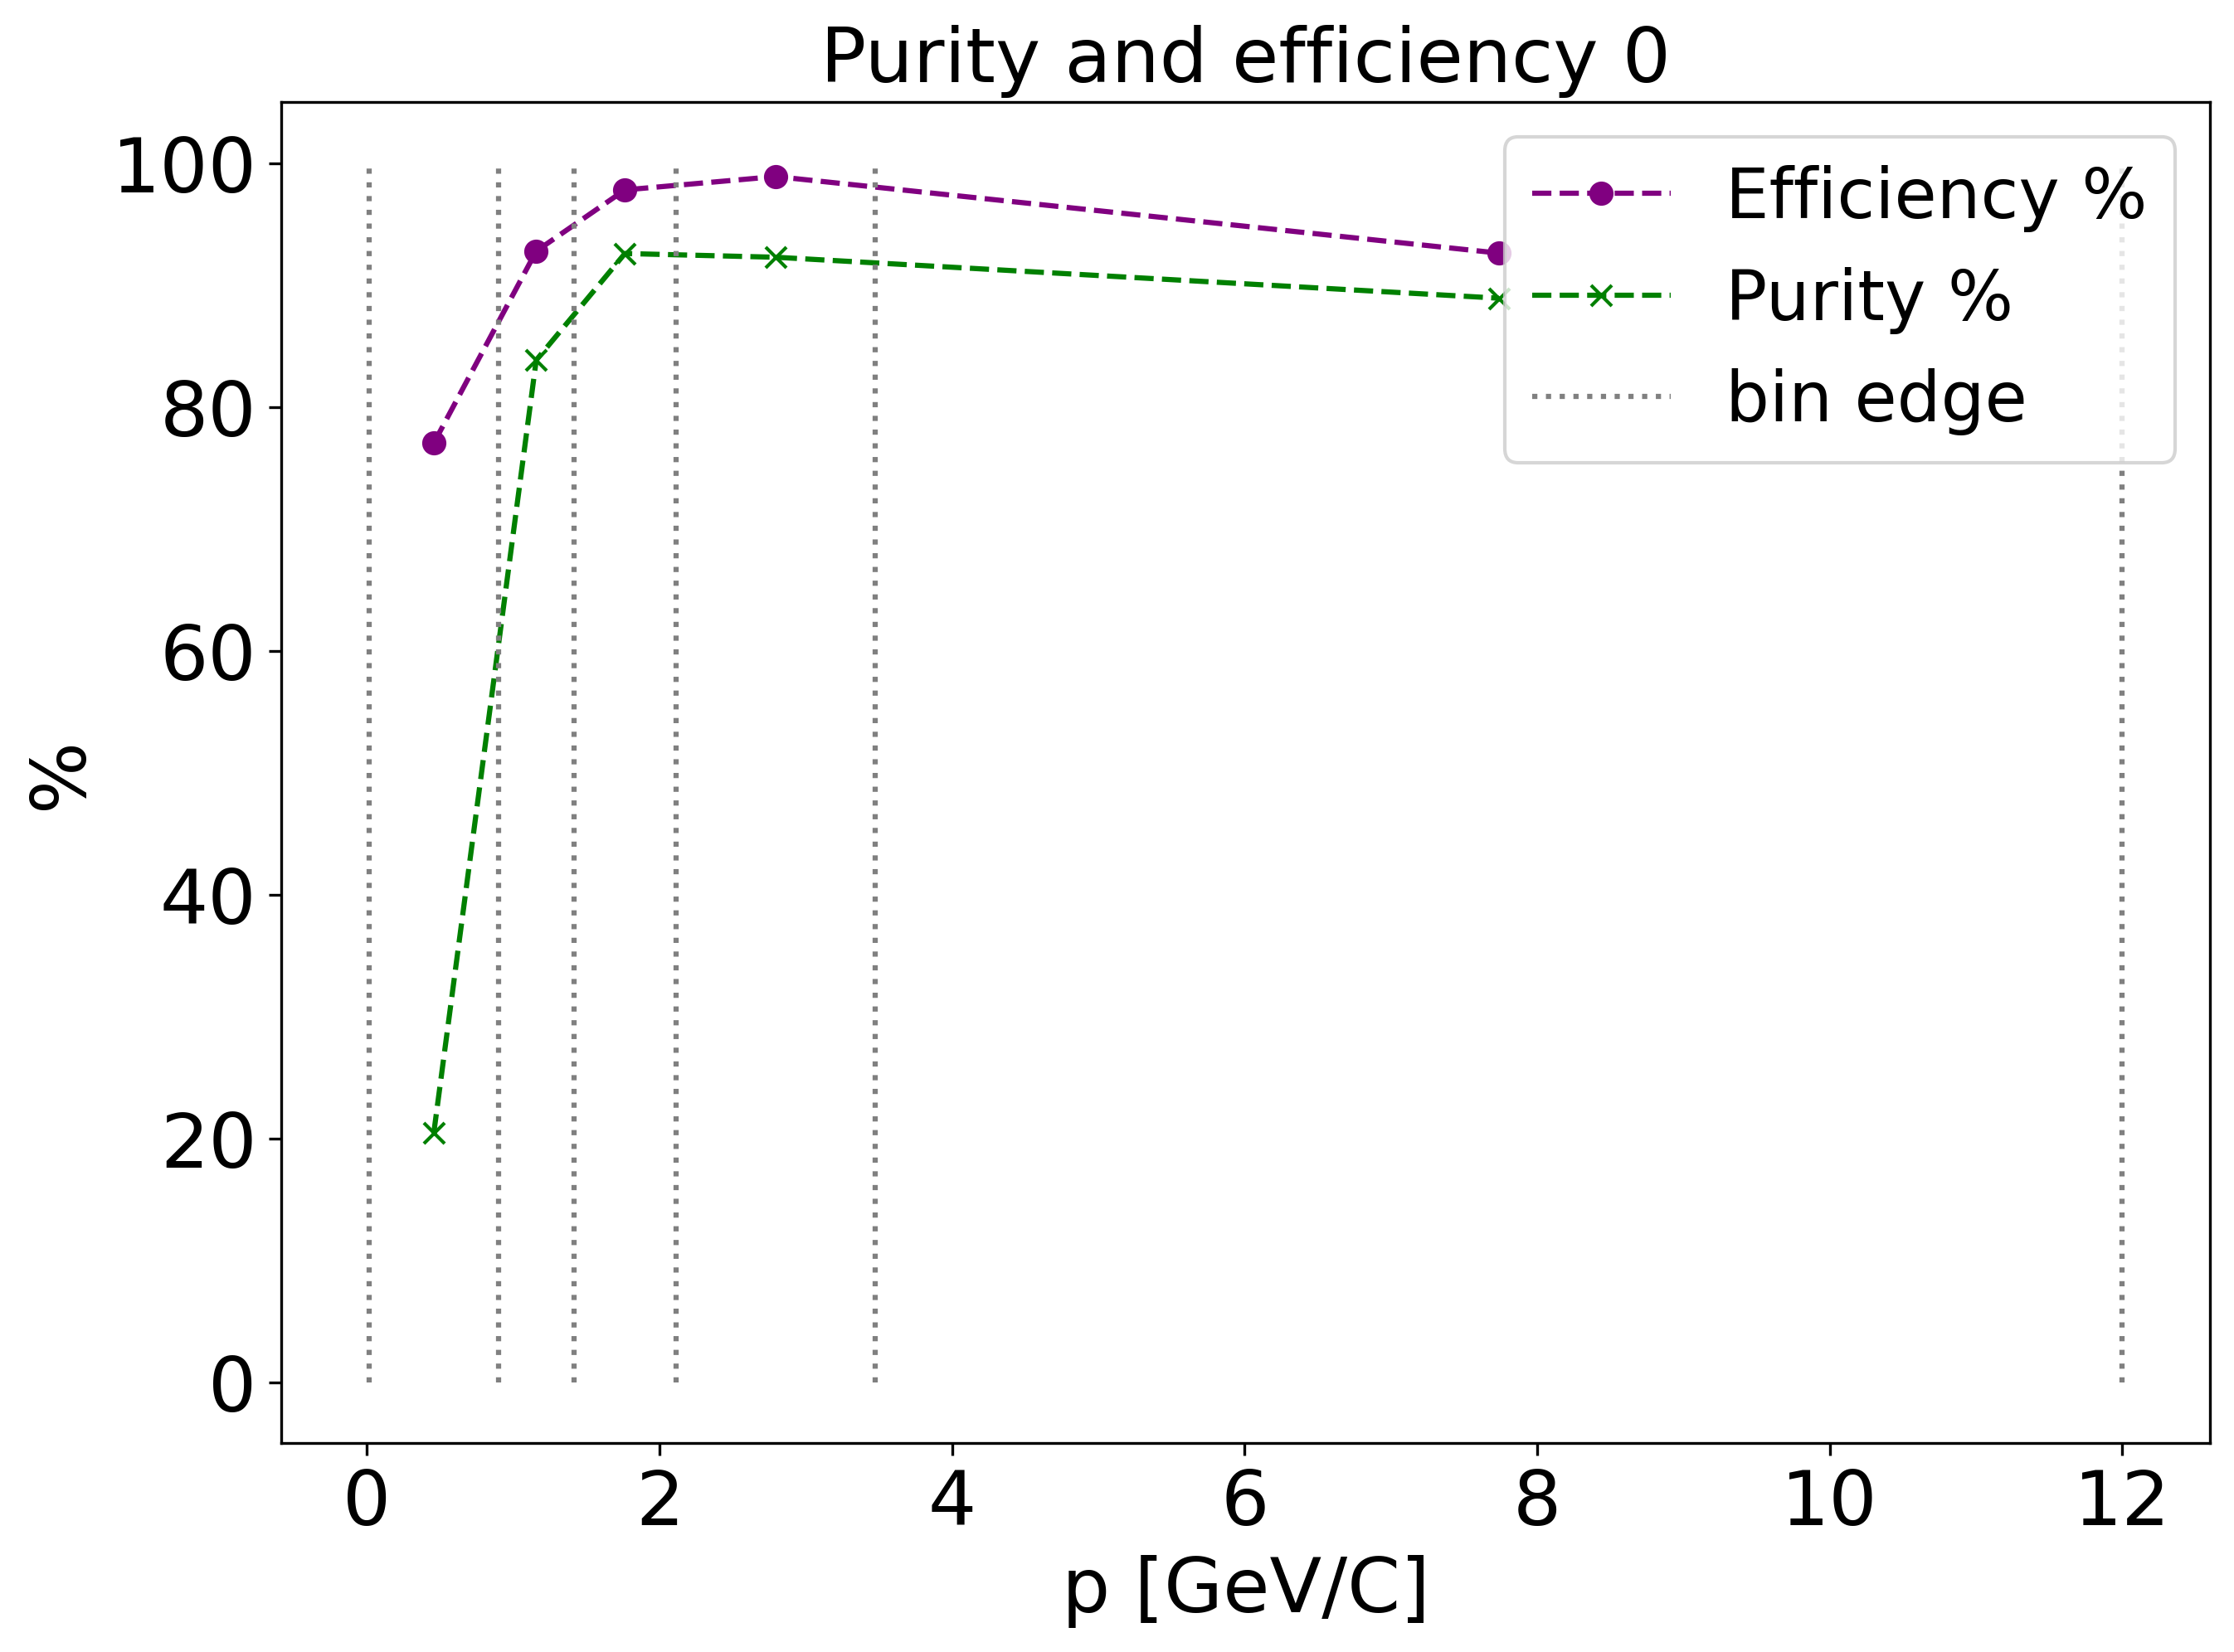

In [97]:
validate.plot_stats(0)
validate.plot_stats(1)
validate.plot_stats(2)

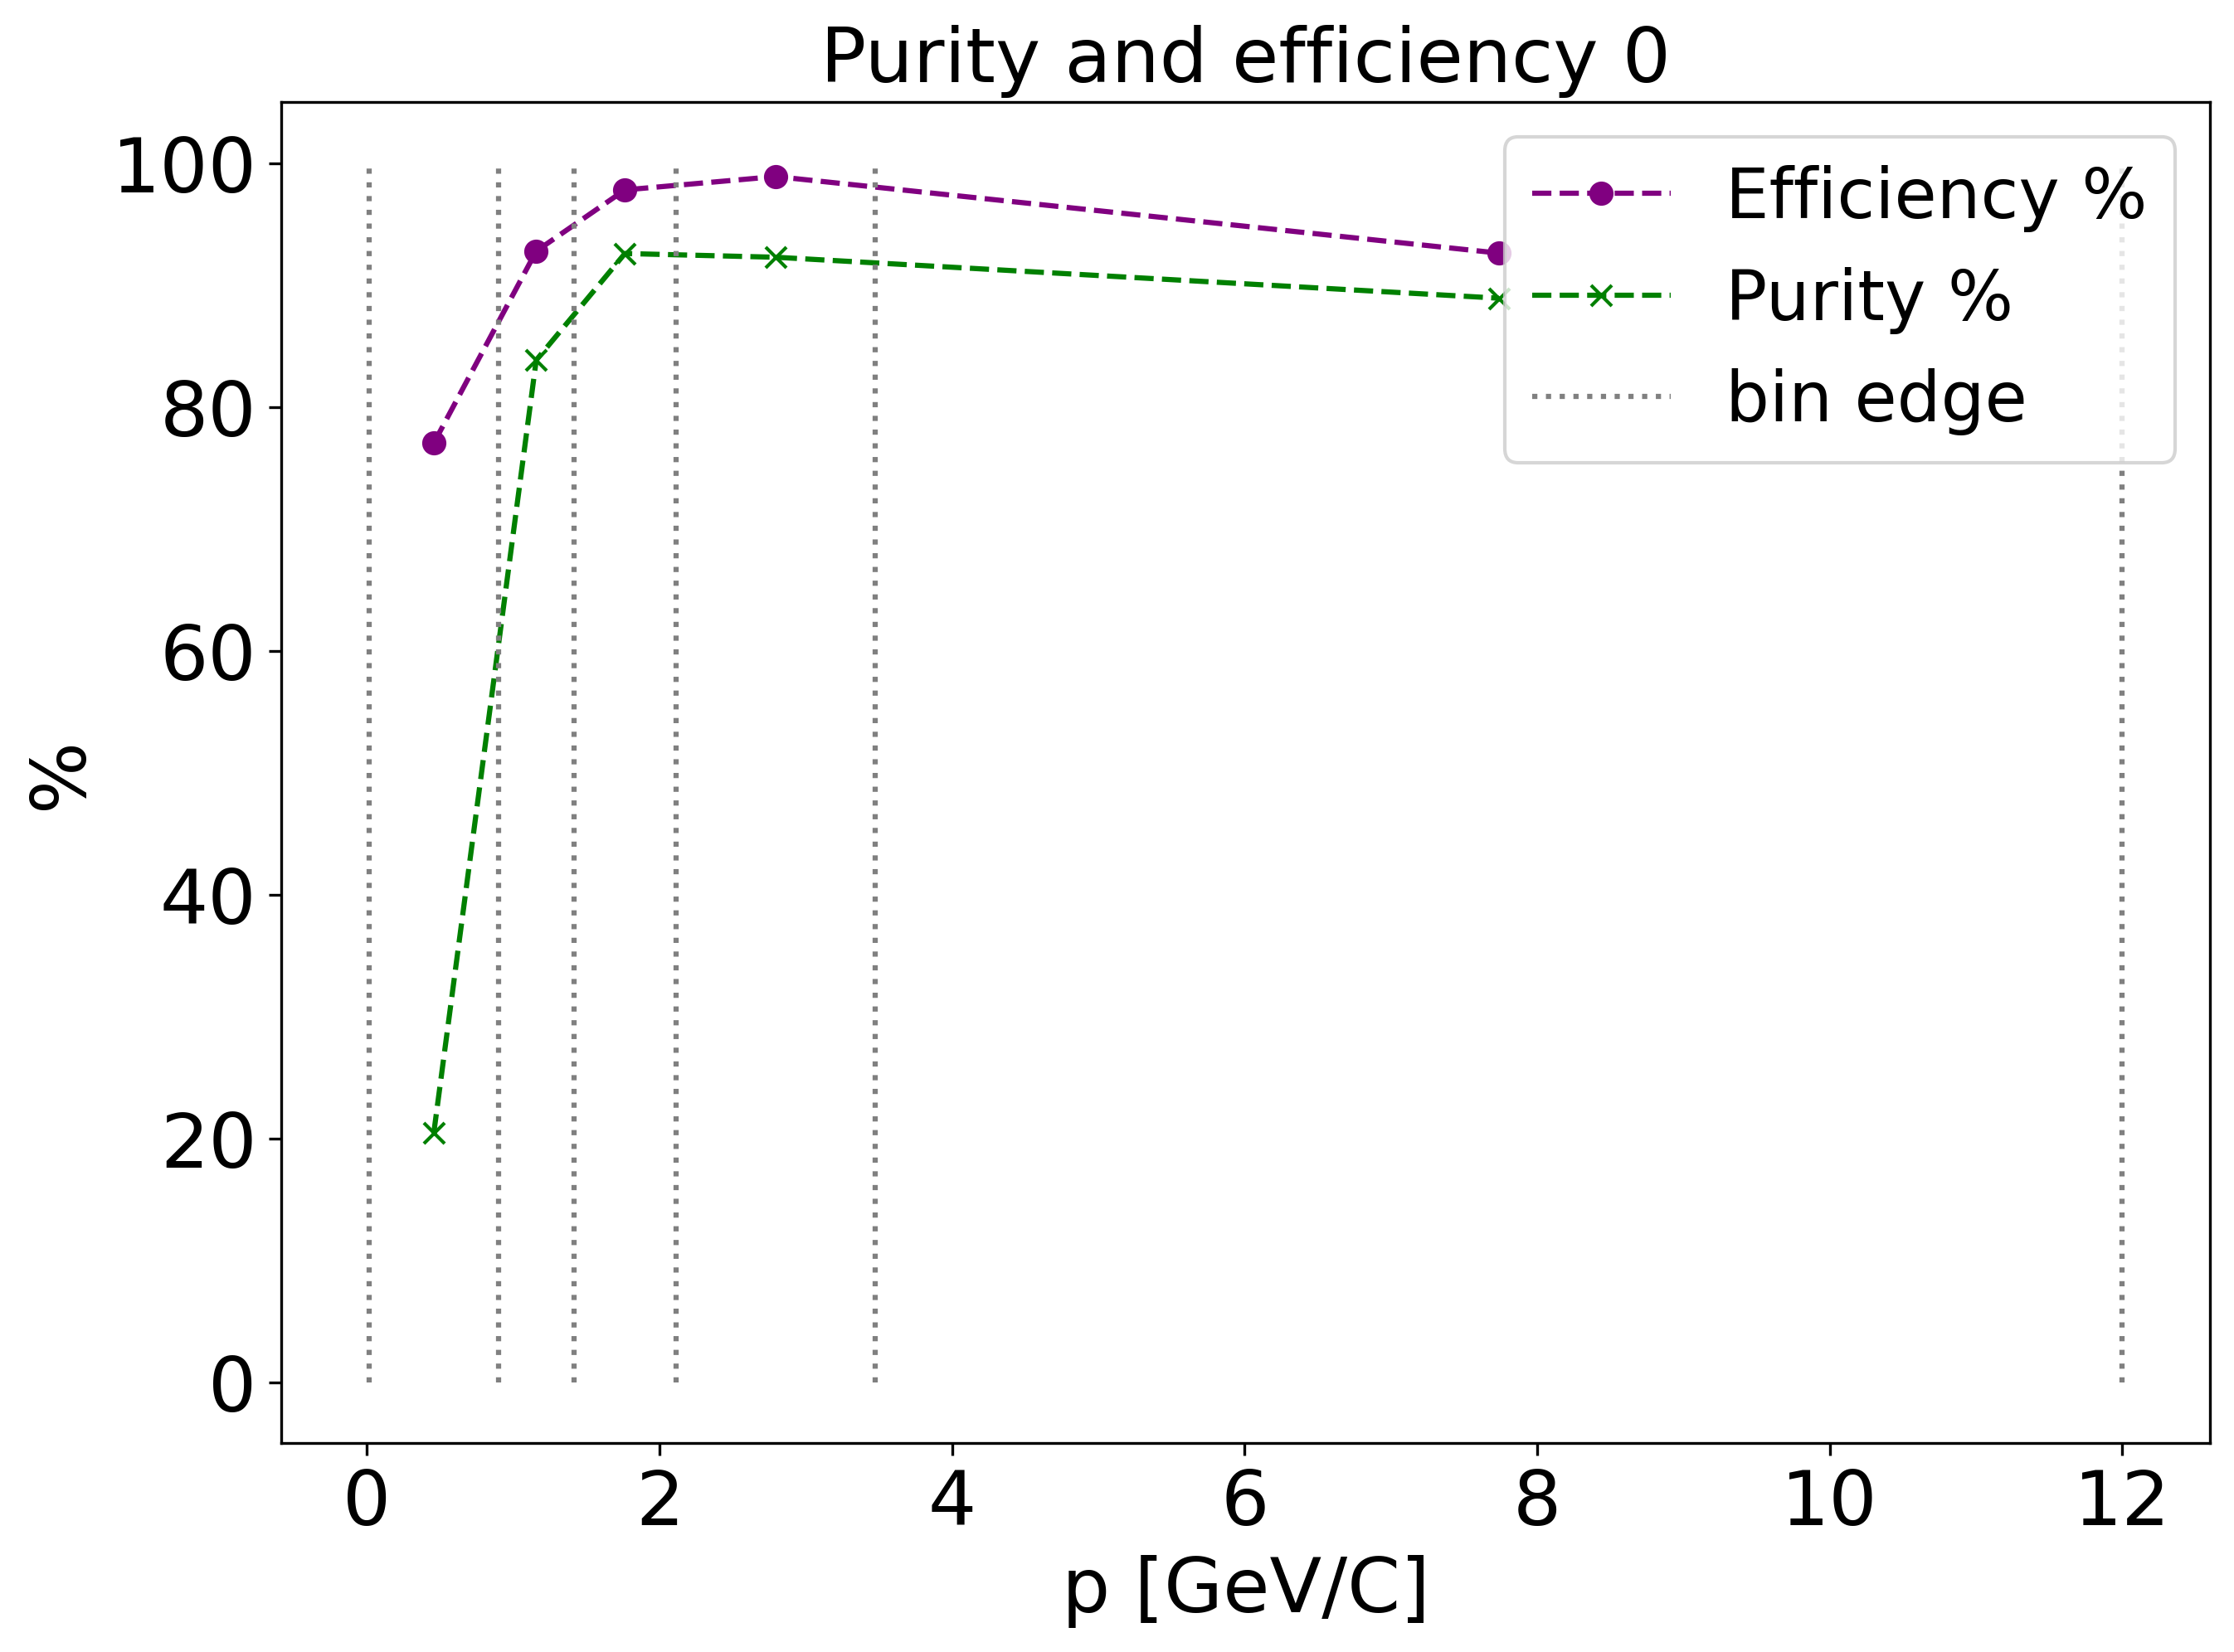